# Evaluation of Synthetic Data Quality vs. Imbalance

This notebook evaluates and compares the quality of synthetic data generated by **CTGAN**, **TVAE**, **DDPM**, and **NFLOW** 
across six imbalance ratios (IRs) and three repetitions per IR. The analysis is structured around three core quality dimensions: 
**Statistical Fidelity**, **Downstream Utility**, and **Privacy Risk**.


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm.notebook import tqdm
import warnings

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, auc
from sklearn.preprocessing import MinMaxScaler

from pymdma.tabular.measures.synthesis_val import (
    ImprovedPrecision,
    ImprovedRecall,
    Density,
    Coverage,
    Authenticity,
)

warnings.filterwarnings("ignore")


In [21]:
BASE_PATH = Path("../")
PROCESSED_PATH = BASE_PATH / "data" / "processed"
SYNTHETIC_PATH = BASE_PATH / "data" / "synthetic"
FIGURES_PATH = BASE_PATH / "results" / "figures"
FIGURES_PATH.mkdir(exist_ok=True, parents=True)

In [22]:
TARGET_FEATURE = "Severity"
IMBALANCE_RATIOS = [1, 5, 10, 20, 50, 100]
GENERATORS = ["ctgan", "tvae", "ddpm", "nflow"]
N_REPETITIONS = 3  

In [23]:
sns.set_theme(style="whitegrid")
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.family'] = 'sans-serif'

palette = sns.color_palette("colorblind", n_colors=len(GENERATORS))
GENERATOR_STYLES = {
    "CTGAN": {"color": palette[0], "marker": "o", "linestyle": "-"},
    "TVAE": {"color": palette[1], "marker": "s", "linestyle": "--"},
    "DDPM": {"color": palette[2], "marker": "X", "linestyle": "-."},
    "NFLOW": {"color": palette[3], "marker": "D", "linestyle": ":"},
}

In [24]:
def calculate_utility_metrics(train_df: pd.DataFrame, test_df: pd.DataFrame) -> dict:
    X_train = train_df.drop(columns=[TARGET_FEATURE])
    y_train = train_df[TARGET_FEATURE]
    X_test = test_df.drop(columns=[TARGET_FEATURE])
    y_test = test_df[TARGET_FEATURE]

    model = RandomForestClassifier(random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)

    y_prob = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    
    return {"pr_auc": auc(recall, precision)}


def calculate_pyMDMA_metrics(real_df: pd.DataFrame, synthetic_df: pd.DataFrame) -> dict:
    real_features = real_df.drop(columns=[TARGET_FEATURE]).to_numpy()
    synthetic_features = synthetic_df.drop(columns=[TARGET_FEATURE]).to_numpy()

    metrics = {
        "precision": ImprovedPrecision(),
        "recall": ImprovedRecall(),
        "density": Density(),
        "coverage": Coverage(),
        "authenticity": Authenticity(),
    }
    
    results = {
        name: metric.compute(real_features, synthetic_features).dataset_level.value
        for name, metric in metrics.items()
    }
    return results



In [25]:
all_results_runs = []
test_df = pd.read_csv(PROCESSED_PATH / "test.csv")

total_evals = len(IMBALANCE_RATIOS) * len(GENERATORS) * N_REPETITIONS
print(f"Starting evaluation of {total_evals} experimental conditions...\n")

pbar = tqdm(total=total_evals, desc="Processing Experiments")

for ir in IMBALANCE_RATIOS:
    for generator in GENERATORS:
        for rep_id in range(1, N_REPETITIONS + 1):
            real_path = PROCESSED_PATH / f"train_imbalanced_ir_{ir}_rep{rep_id}.csv"
            synth_path = SYNTHETIC_PATH / f"train_imbalanced_ir_{ir}_rep{rep_id}_balanced_by_{generator}.csv"

            if not synth_path.exists():
                warnings.warn(f"File not found, skipping: {synth_path.name}")
                pbar.update(1)
                continue

            real_df = pd.read_csv(real_path)
            synthetic_df = pd.read_csv(synth_path)

            pyMDMA_metrics = calculate_pyMDMA_metrics(real_df, synthetic_df)
            utility_metrics = calculate_utility_metrics(synthetic_df, test_df)

            result_entry = {
                "ir": ir,
                "generator": generator.upper(),
                "repetition_id": rep_id,
                **pyMDMA_metrics,
                **utility_metrics
            }
            all_results_runs.append(result_entry)
            pbar.update(1)

pbar.close()
raw_results_df = pd.DataFrame(all_results_runs)

Starting evaluation of 72 experimental conditions...



Processing Experiments:   0%|          | 0/72 [00:00<?, ?it/s]

In [26]:
metric_columns = [col for col in raw_results_df.columns 
                 if col not in ['ir', 'generator', 'repetition_id']]

agg_dict = {col: ['mean', 'std'] for col in metric_columns}

results_df = raw_results_df.groupby(['ir', 'generator']).agg(agg_dict).reset_index()

results_df.columns = ['_'.join(col).strip() if col[1] else col[0] 
                      for col in results_df.columns.values]

example = raw_results_df[(raw_results_df['ir'] == 20) & (raw_results_df['generator'] == 'TVAE')]
if not example.empty:
    print(example[['repetition_id', 'precision', 'density', 'pr_auc', 'authenticity']].to_string(index=False))
    print(f"\nPR-AUC Range: {example['pr_auc'].min():.4f} - {example['pr_auc'].max():.4f}")
    print(f"PR-AUC Std Dev: {example['pr_auc'].std():.4f}")
else:
    print("No data available for this example")

results_df.head()


 repetition_id  precision  density   pr_auc  authenticity
             1   0.992718 1.225243 0.811880      0.156553
             2   0.996359 1.316748 0.817337      0.166262
             3   0.997573 1.378398 0.816077      0.134709

PR-AUC Range: 0.8119 - 0.8173
PR-AUC Std Dev: 0.0029


,ir,generator,precision_mean,precision_std,recall_mean,recall_std,density_mean,density_std,coverage_mean,coverage_std,authenticity_mean,authenticity_std,pr_auc_mean,pr_auc_std
0,5,CTGAN,0.989482,0.009427,1.0,0.0,1.218770,0.125591,1.0,0.0,0.157767,0.108554,0.804235,0.019069
1,5,DDPM,0.992314,0.003054,1.0,0.0,1.240534,0.006311,1.0,0.0,0.179207,0.007315,0.801206,0.019359
2,5,NFLOW,0.989078,0.001214,1.0,0.0,1.208495,0.006766,1.0,0.0,0.169903,0.015870,0.797177,0.027584
3,5,TVAE,0.997977,0.001401,1.0,0.0,1.299029,0.040472,1.0,0.0,0.110841,0.032594,0.805126,0.018087
4,10,CTGAN,0.918285,0.131047,1.0,0.0,1.140291,0.172573,1.0,0.0,0.207524,0.130160,0.799127,0.011556


### Performance Trends vs. Imbalance Ratio

- Lines show mean performance across 3 repetitions
- Shaded bands show ±1 standard deviation
- Wider bands = more sensitive to which minority samples are available


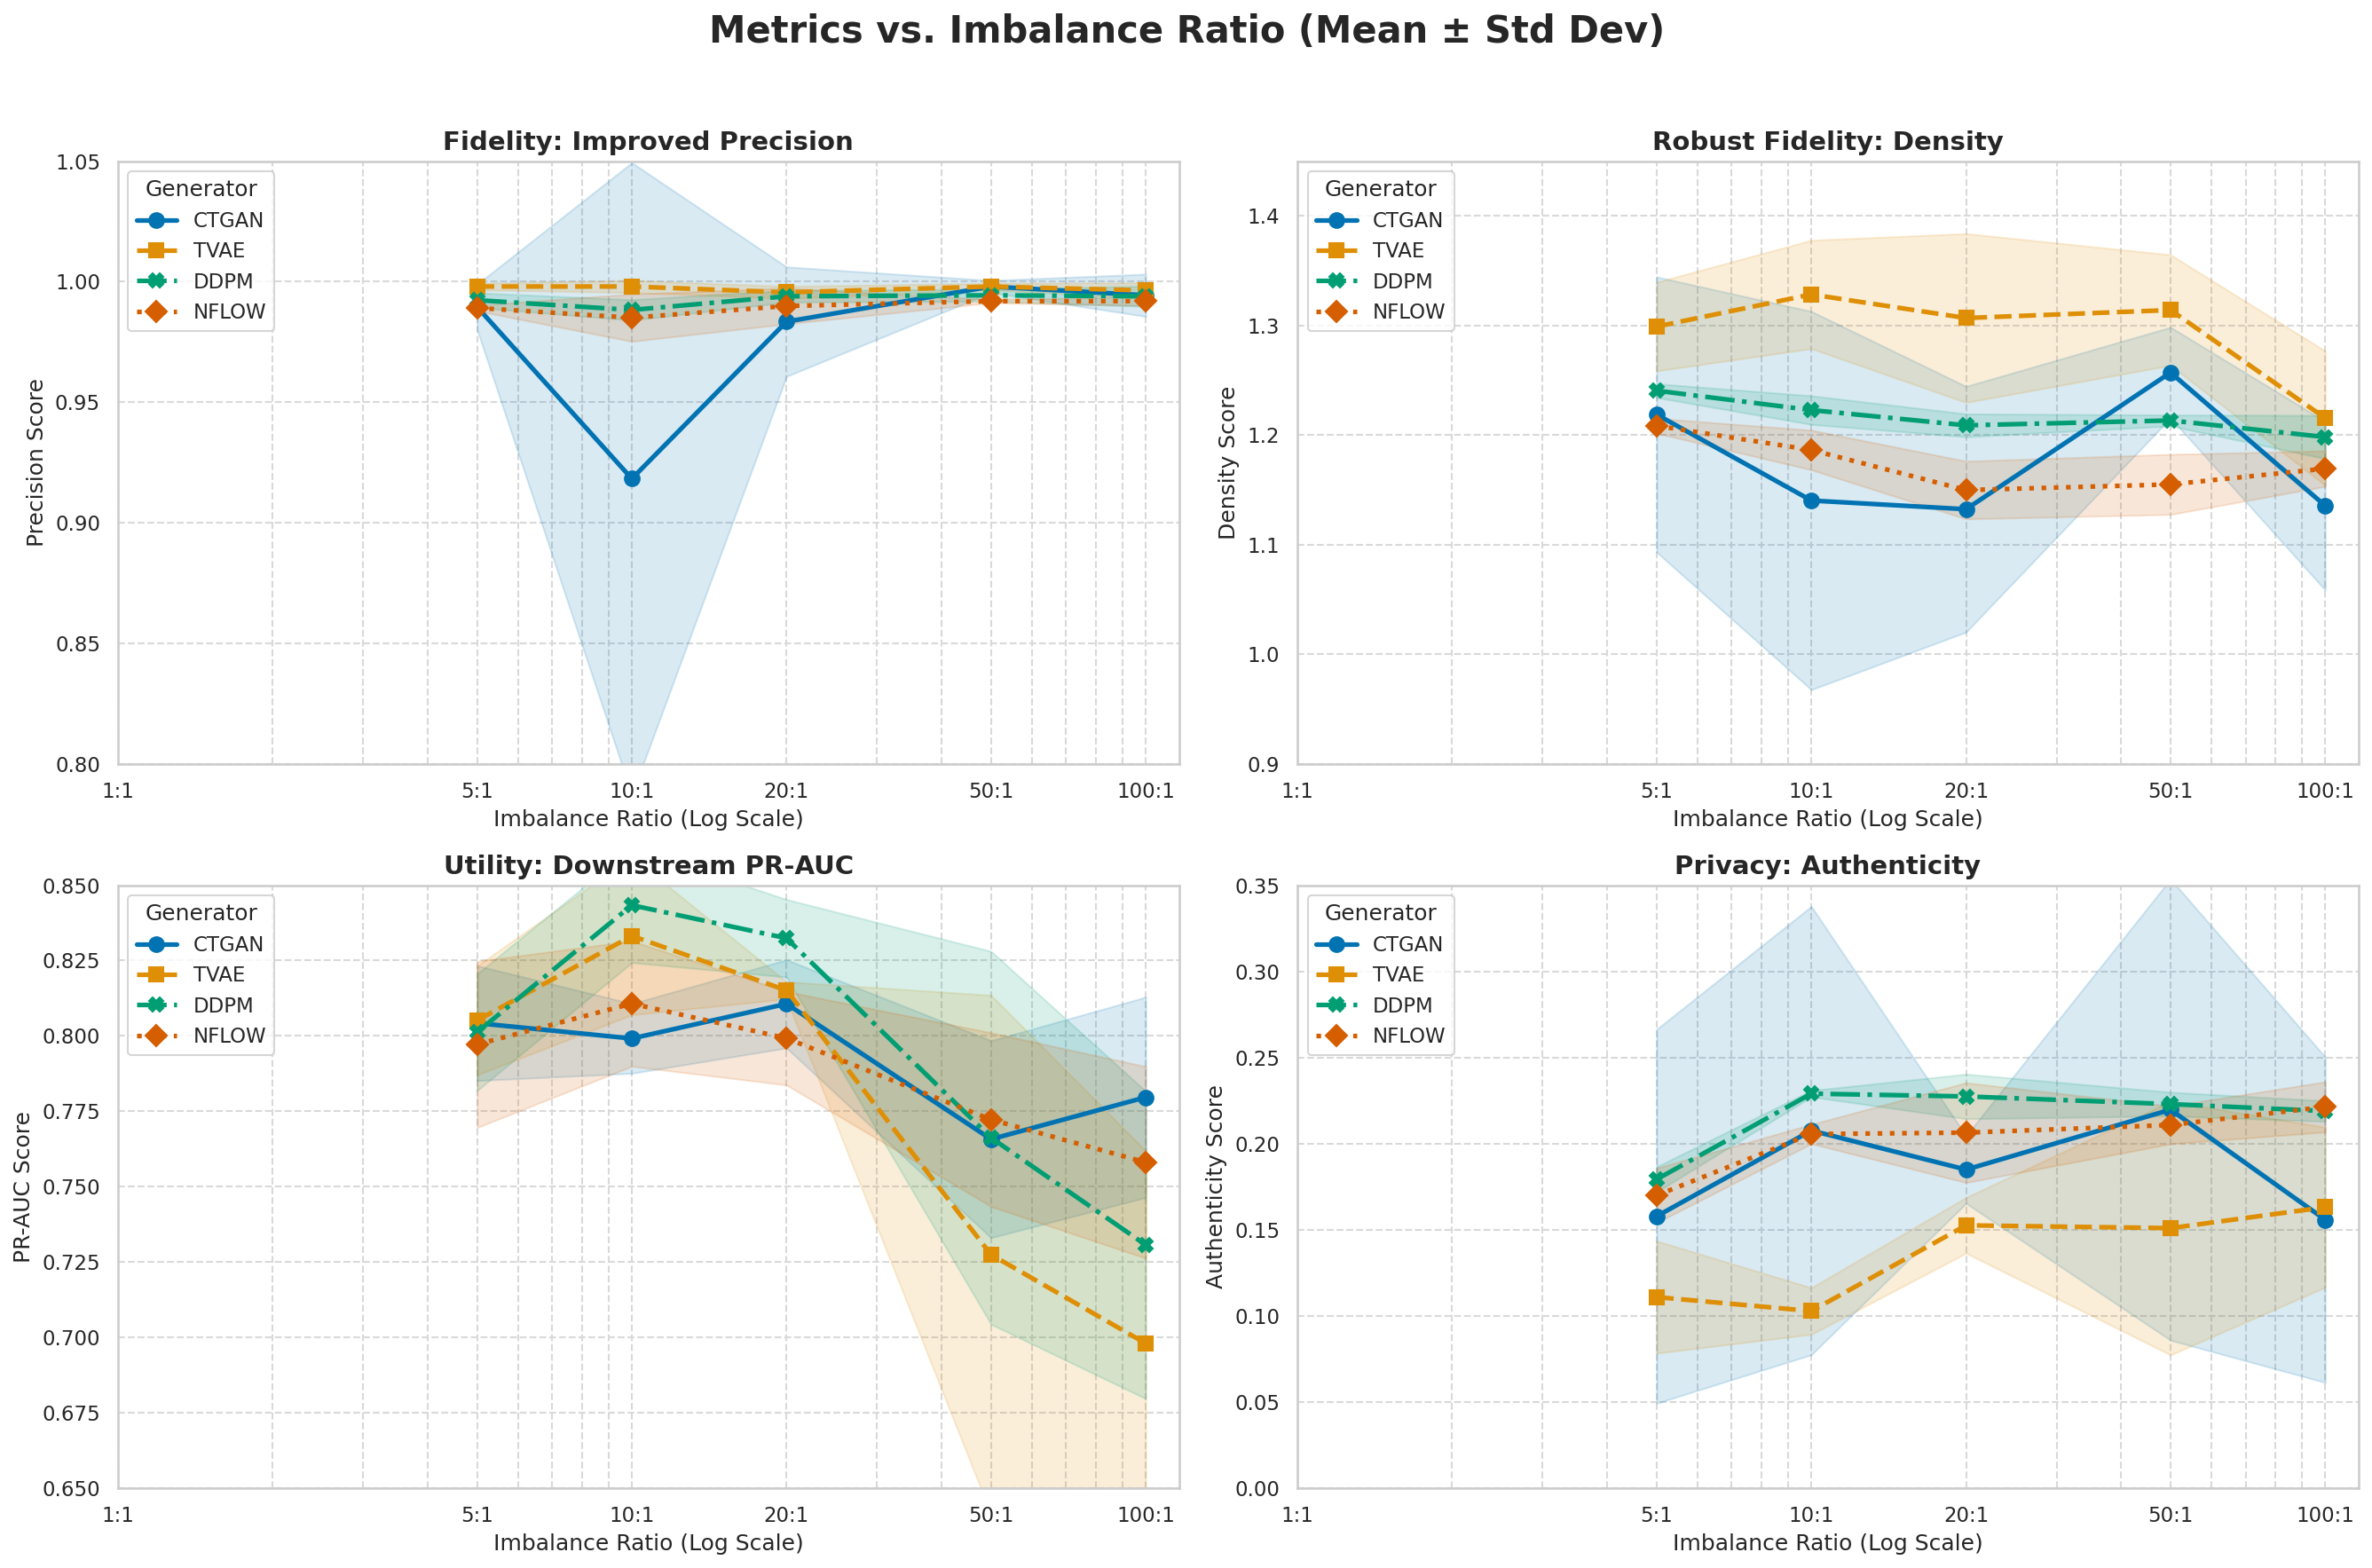

In [27]:
def plot_metric_trend(data, metric, ax, title, y_label, y_lim=(0, None)):
    metric_mean = f"{metric}_mean"
    metric_std = f"{metric}_std"
    
    for gen, style in GENERATOR_STYLES.items():
        gen_data = data[data['generator'] == gen]
        if gen_data.empty:
            continue
            
        ax.plot(
            gen_data['ir'], 
            gen_data[metric_mean],
            color=style['color'],
            marker=style['marker'],
            linestyle=style['linestyle'],
            label=gen,
            markersize=8, 
            linewidth=2.5
        )
        
        std_dev = gen_data[metric_std].fillna(0)
        ax.fill_between(
            gen_data['ir'],
            gen_data[metric_mean] - std_dev,
            gen_data[metric_mean] + std_dev,
            color=style['color'],
            alpha=0.15
        )

    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_ylabel(y_label, fontsize=12)
    ax.set_xlabel('Imbalance Ratio (Log Scale)', fontsize=12)
    ax.set_xscale('log')
    ax.set_xticks(IMBALANCE_RATIOS)
    ax.set_xticklabels([f"{ir}:1" for ir in IMBALANCE_RATIOS])
    if y_lim:
        ax.set_ylim(y_lim)
    ax.legend(title='Generator', loc='best')
    ax.grid(True, which="both", ls="--", c='0.85')


fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Metrics vs. Imbalance Ratio (Mean ± Std Dev)', 
             fontsize=20, fontweight='bold')

plot_metric_trend(results_df, 'precision', axes[0, 0], 'Fidelity: Improved Precision', 'Precision Score', y_lim=(0.8, 1.05))
plot_metric_trend(results_df, 'density', axes[0, 1], 'Robust Fidelity: Density', 'Density Score', y_lim=(0.9, 1.45))
plot_metric_trend(results_df, 'pr_auc', axes[1, 0], 'Utility: Downstream PR-AUC', 'PR-AUC Score', y_lim=(0.65, 0.85))
plot_metric_trend(results_df, 'authenticity', axes[1, 1], 'Privacy: Authenticity', 'Authenticity Score', y_lim=(0, 0.35))

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(FIGURES_PATH / 'improved_quality_trends_with_error.png', dpi=300)
plt.show()

In [28]:
output_ratio_results = []

for ir in IMBALANCE_RATIOS:
    for generator in GENERATORS:
        for rep_id in range(1, N_REPETITIONS + 1):
            synth_path = SYNTHETIC_PATH / f"train_imbalanced_ir_{ir}_rep{rep_id}_balanced_by_{generator}.csv"
            
            if not synth_path.exists():
                continue
            
            synthetic_df = pd.read_csv(synth_path)
            value_counts = synthetic_df[TARGET_FEATURE].value_counts()
            
            if len(value_counts) >= 2 and value_counts.min() > 0:
                output_ir = value_counts.max() / value_counts.min()
                output_ratio_results.append({
                    'input_ir': ir,
                    'generator': generator.upper(),
                    'repetition_id': rep_id,
                    'output_ir': round(output_ir, 2),
                    'n_majority': int(value_counts.max()),
                    'n_minority': int(value_counts.min())
                })

output_ratio_df = pd.DataFrame(output_ratio_results)

results_with_output_ir = raw_results_df.merge(
    output_ratio_df, 
    left_on=['ir', 'generator', 'repetition_id'],
    right_on=['input_ir', 'generator', 'repetition_id'],
    how='left'
)

# Aggregate by output_ir and generator
metric_columns = ['precision', 'recall', 'density', 'coverage', 'authenticity', 'pr_auc']
agg_dict_output = {col: ['mean', 'std'] for col in metric_columns}
agg_dict_output['input_ir'] = 'first'  

results_by_output_ir = results_with_output_ir.groupby(['output_ir', 'generator']).agg(agg_dict_output).reset_index()

results_by_output_ir.columns = ['_'.join(col).strip() if col[1] else col[0] 
                                 for col in results_by_output_ir.columns.values]

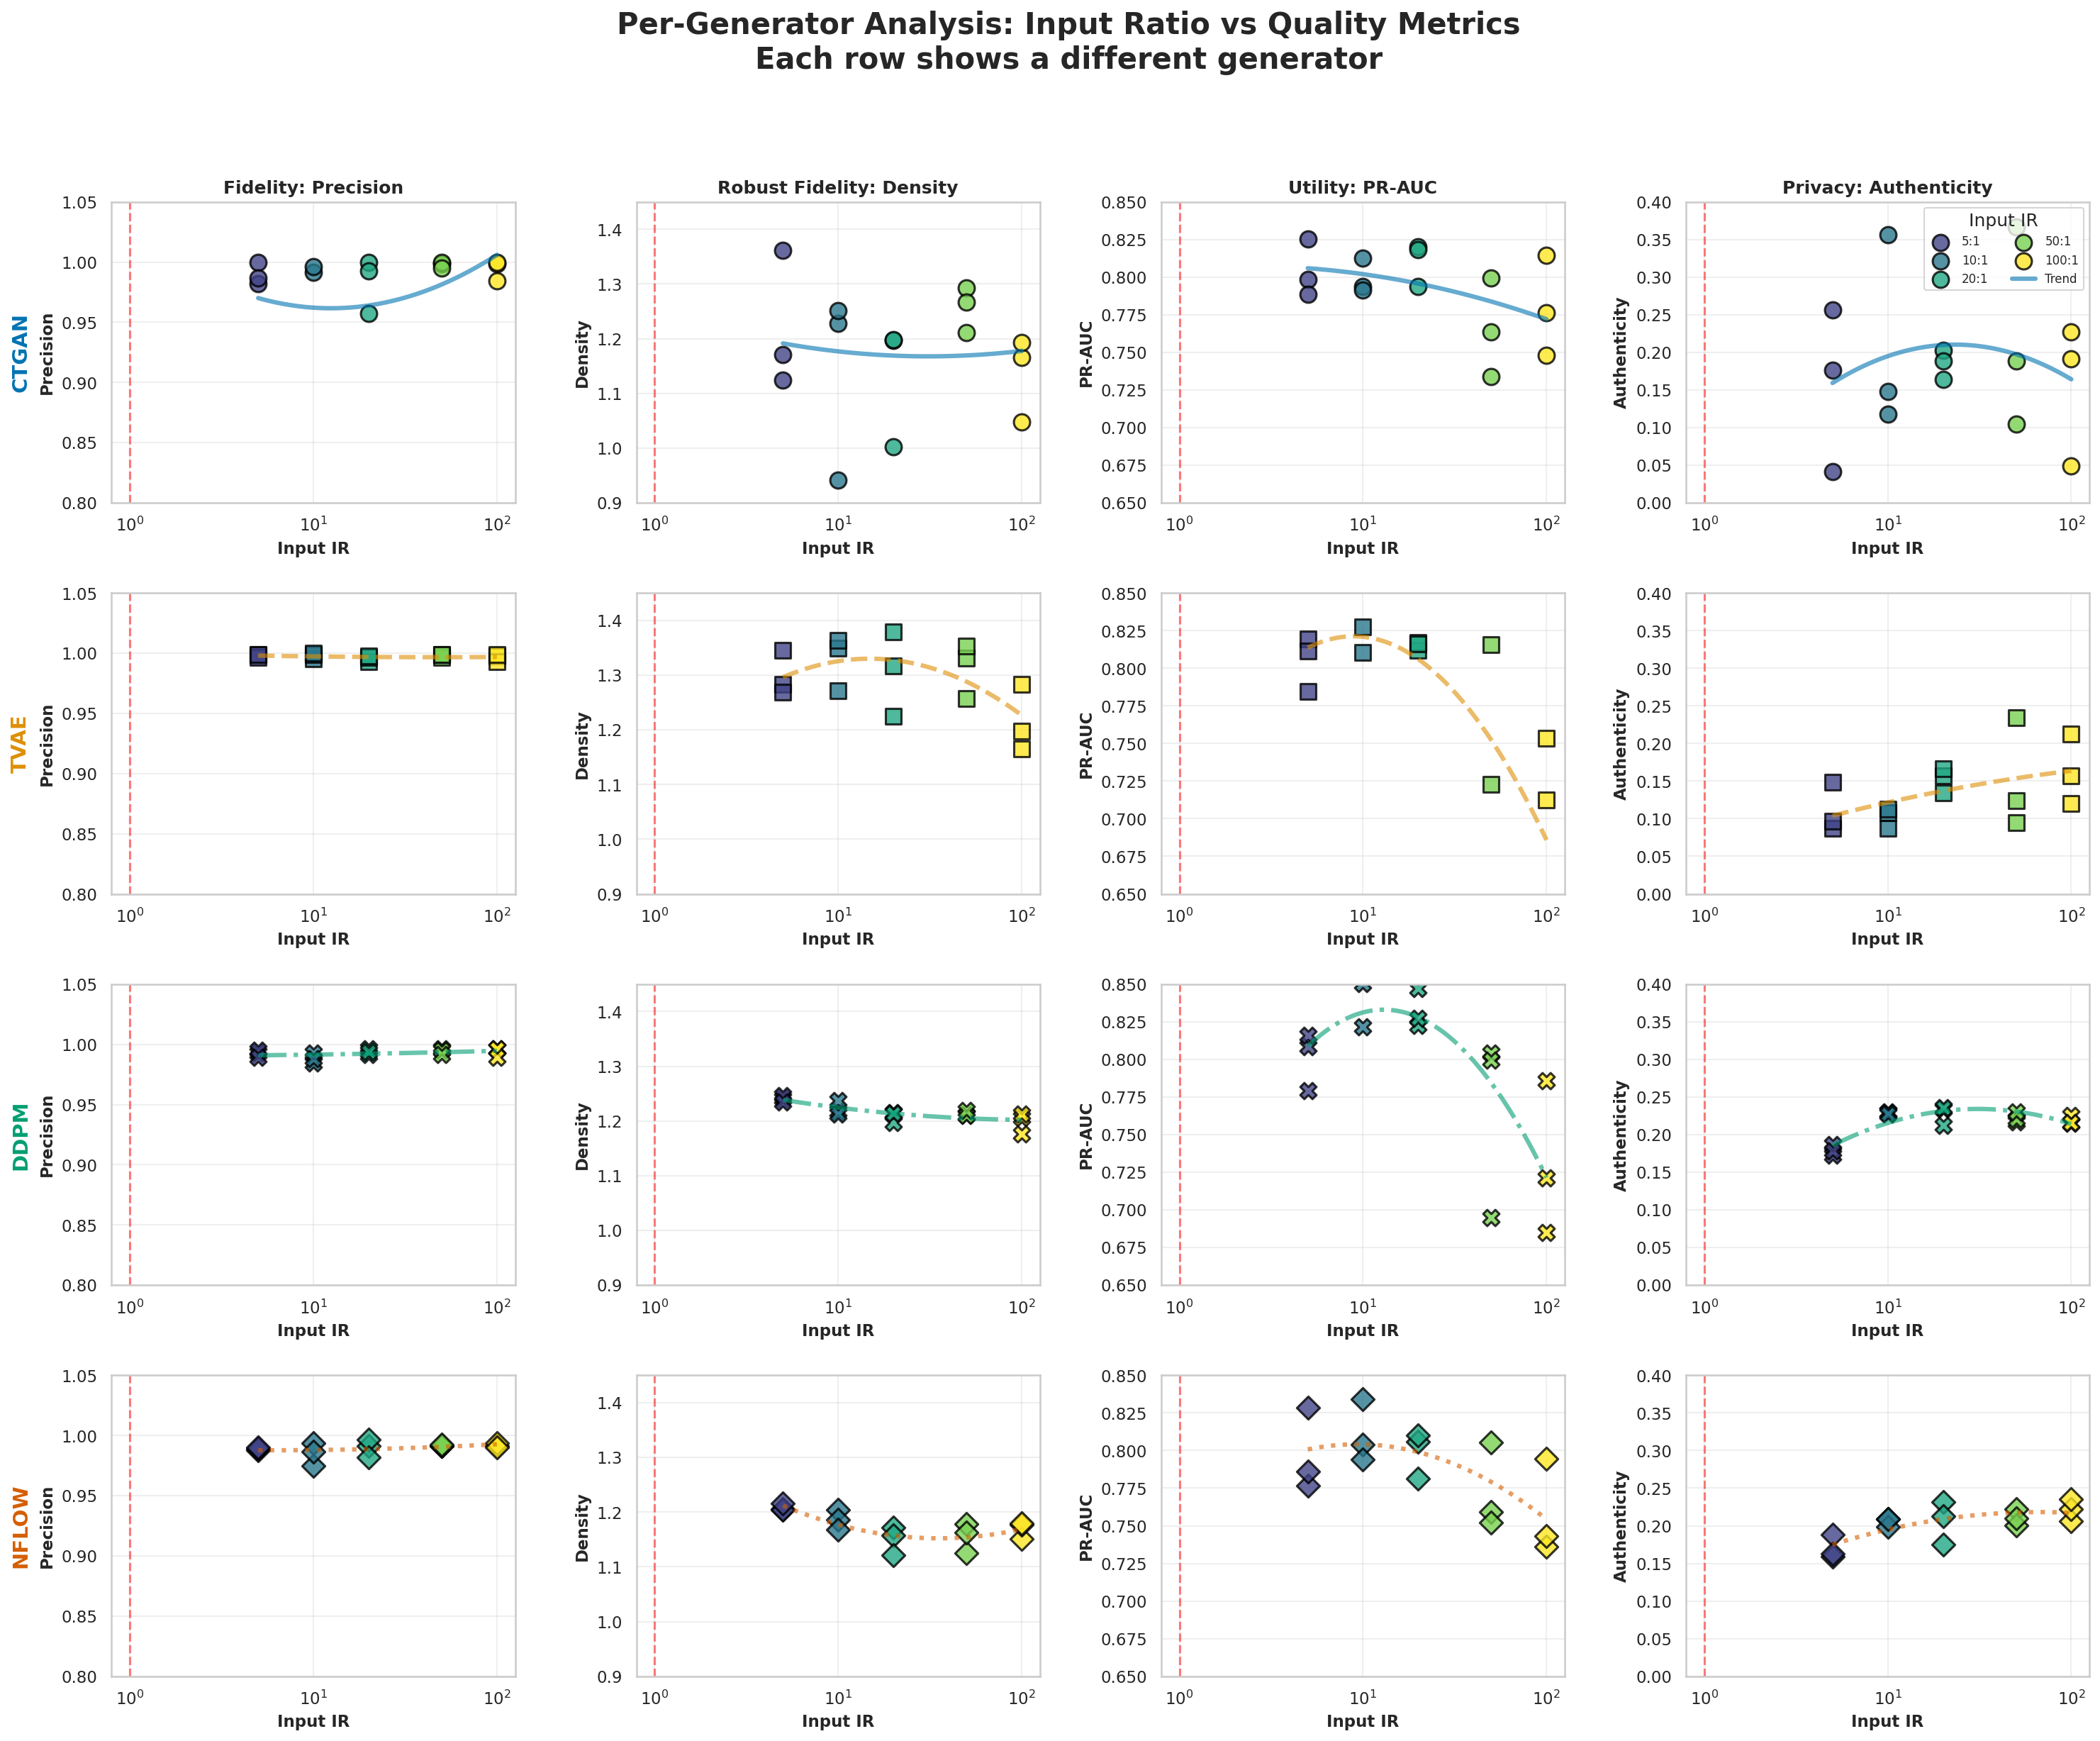


Faceted per-generator plot saved to: ../results/figures/output_ratio_per_generator_faceted.png


In [29]:
metrics = ['precision', 'density', 'pr_auc', 'authenticity']
titles = ['Fidelity: Precision', 'Robust Fidelity: Density', 'Utility: PR-AUC', 'Privacy: Authenticity']
y_lims = [(0.8, 1.05), (0.9, 1.45), (0.65, 0.85), (0, 0.4)]
input_ir_colors = plt.cm.viridis(np.linspace(0, 1, len(IMBALANCE_RATIOS)))
input_ir_color_map = dict(zip(IMBALANCE_RATIOS, input_ir_colors))


fig = plt.figure(figsize=(24, 18))
gs = fig.add_gridspec(4, 4, hspace=0.3, wspace=0.3)

fig.suptitle('Per-Generator Analysis: Input Ratio vs Quality Metrics\n' + 
             'Each row shows a different generator', 
             fontsize=20, fontweight='bold')

for gen_idx, (gen, style) in enumerate(GENERATOR_STYLES.items()):
    gen_data = results_with_output_ir[results_with_output_ir['generator'] == gen]
    
    for metric_idx, (metric, metric_title, y_lim) in enumerate(zip(metrics, titles, y_lims)):
        ax = fig.add_subplot(gs[gen_idx, metric_idx])
        
        if not gen_data.empty:
            for ir in IMBALANCE_RATIOS:
                ir_data = gen_data[gen_data['input_ir'] == ir]
                if not ir_data.empty:
                    ax.scatter(
                        ir_data['input_ir'],
                        ir_data[metric],
                        color=input_ir_color_map[ir],
                        marker=style['marker'],
                        s=120,
                        alpha=0.8,
                        edgecolors='black',
                        linewidths=1.5,
                        label=f'{ir}:1'
                    )
            
            valid_data = gen_data[gen_data['input_ir'].notna() & gen_data[metric].notna()]
            if len(valid_data) > 3:
                # Fit polynomial
                log_input_ir = np.log10(valid_data['input_ir'].values)
                metric_vals = valid_data[metric].values
                
                mask = np.isfinite(log_input_ir) & np.isfinite(metric_vals)
                if mask.sum() > 3:
                    z = np.polyfit(log_input_ir[mask], metric_vals[mask], 2)
                    p = np.poly1d(z)
                    
                    x_smooth = np.linspace(log_input_ir[mask].min(), log_input_ir[mask].max(), 100)
                    y_smooth = p(x_smooth)
                    
                    ax.plot(10**x_smooth, y_smooth, color=style['color'], 
                           linewidth=3, linestyle=style['linestyle'], alpha=0.6, 
                           label='Trend')
        
        ax.set_xscale('log')
        ax.set_xlabel('Input IR', fontsize=11, fontweight='bold')
        ax.set_ylabel(metric_title.split(':')[1].strip() if ':' in metric_title else metric_title, 
                     fontsize=11, fontweight='bold')
        
        if y_lim:
            ax.set_ylim(y_lim)
        
        ax.grid(True, alpha=0.3)
        ax.axvline(x=1, color='red', linestyle='--', linewidth=1.5, alpha=0.5)
        
        if gen_idx == 0:
            ax.set_title(metric_title, fontsize=12, fontweight='bold')
        
        if metric_idx == 0:
            ax.text(-0.25, 0.5, gen, transform=ax.transAxes,
                   fontsize=14, fontweight='bold', rotation=90,
                   verticalalignment='center', color=style['color'])
        
        if gen_idx == 0 and metric_idx == 3:
            ax.legend(title='Input IR', fontsize=8, loc='upper right', ncol=2)

plt.savefig(FIGURES_PATH / 'output_ratio_per_generator_faceted.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nFaceted per-generator plot saved to:", FIGURES_PATH / 'output_ratio_per_generator_faceted.png')

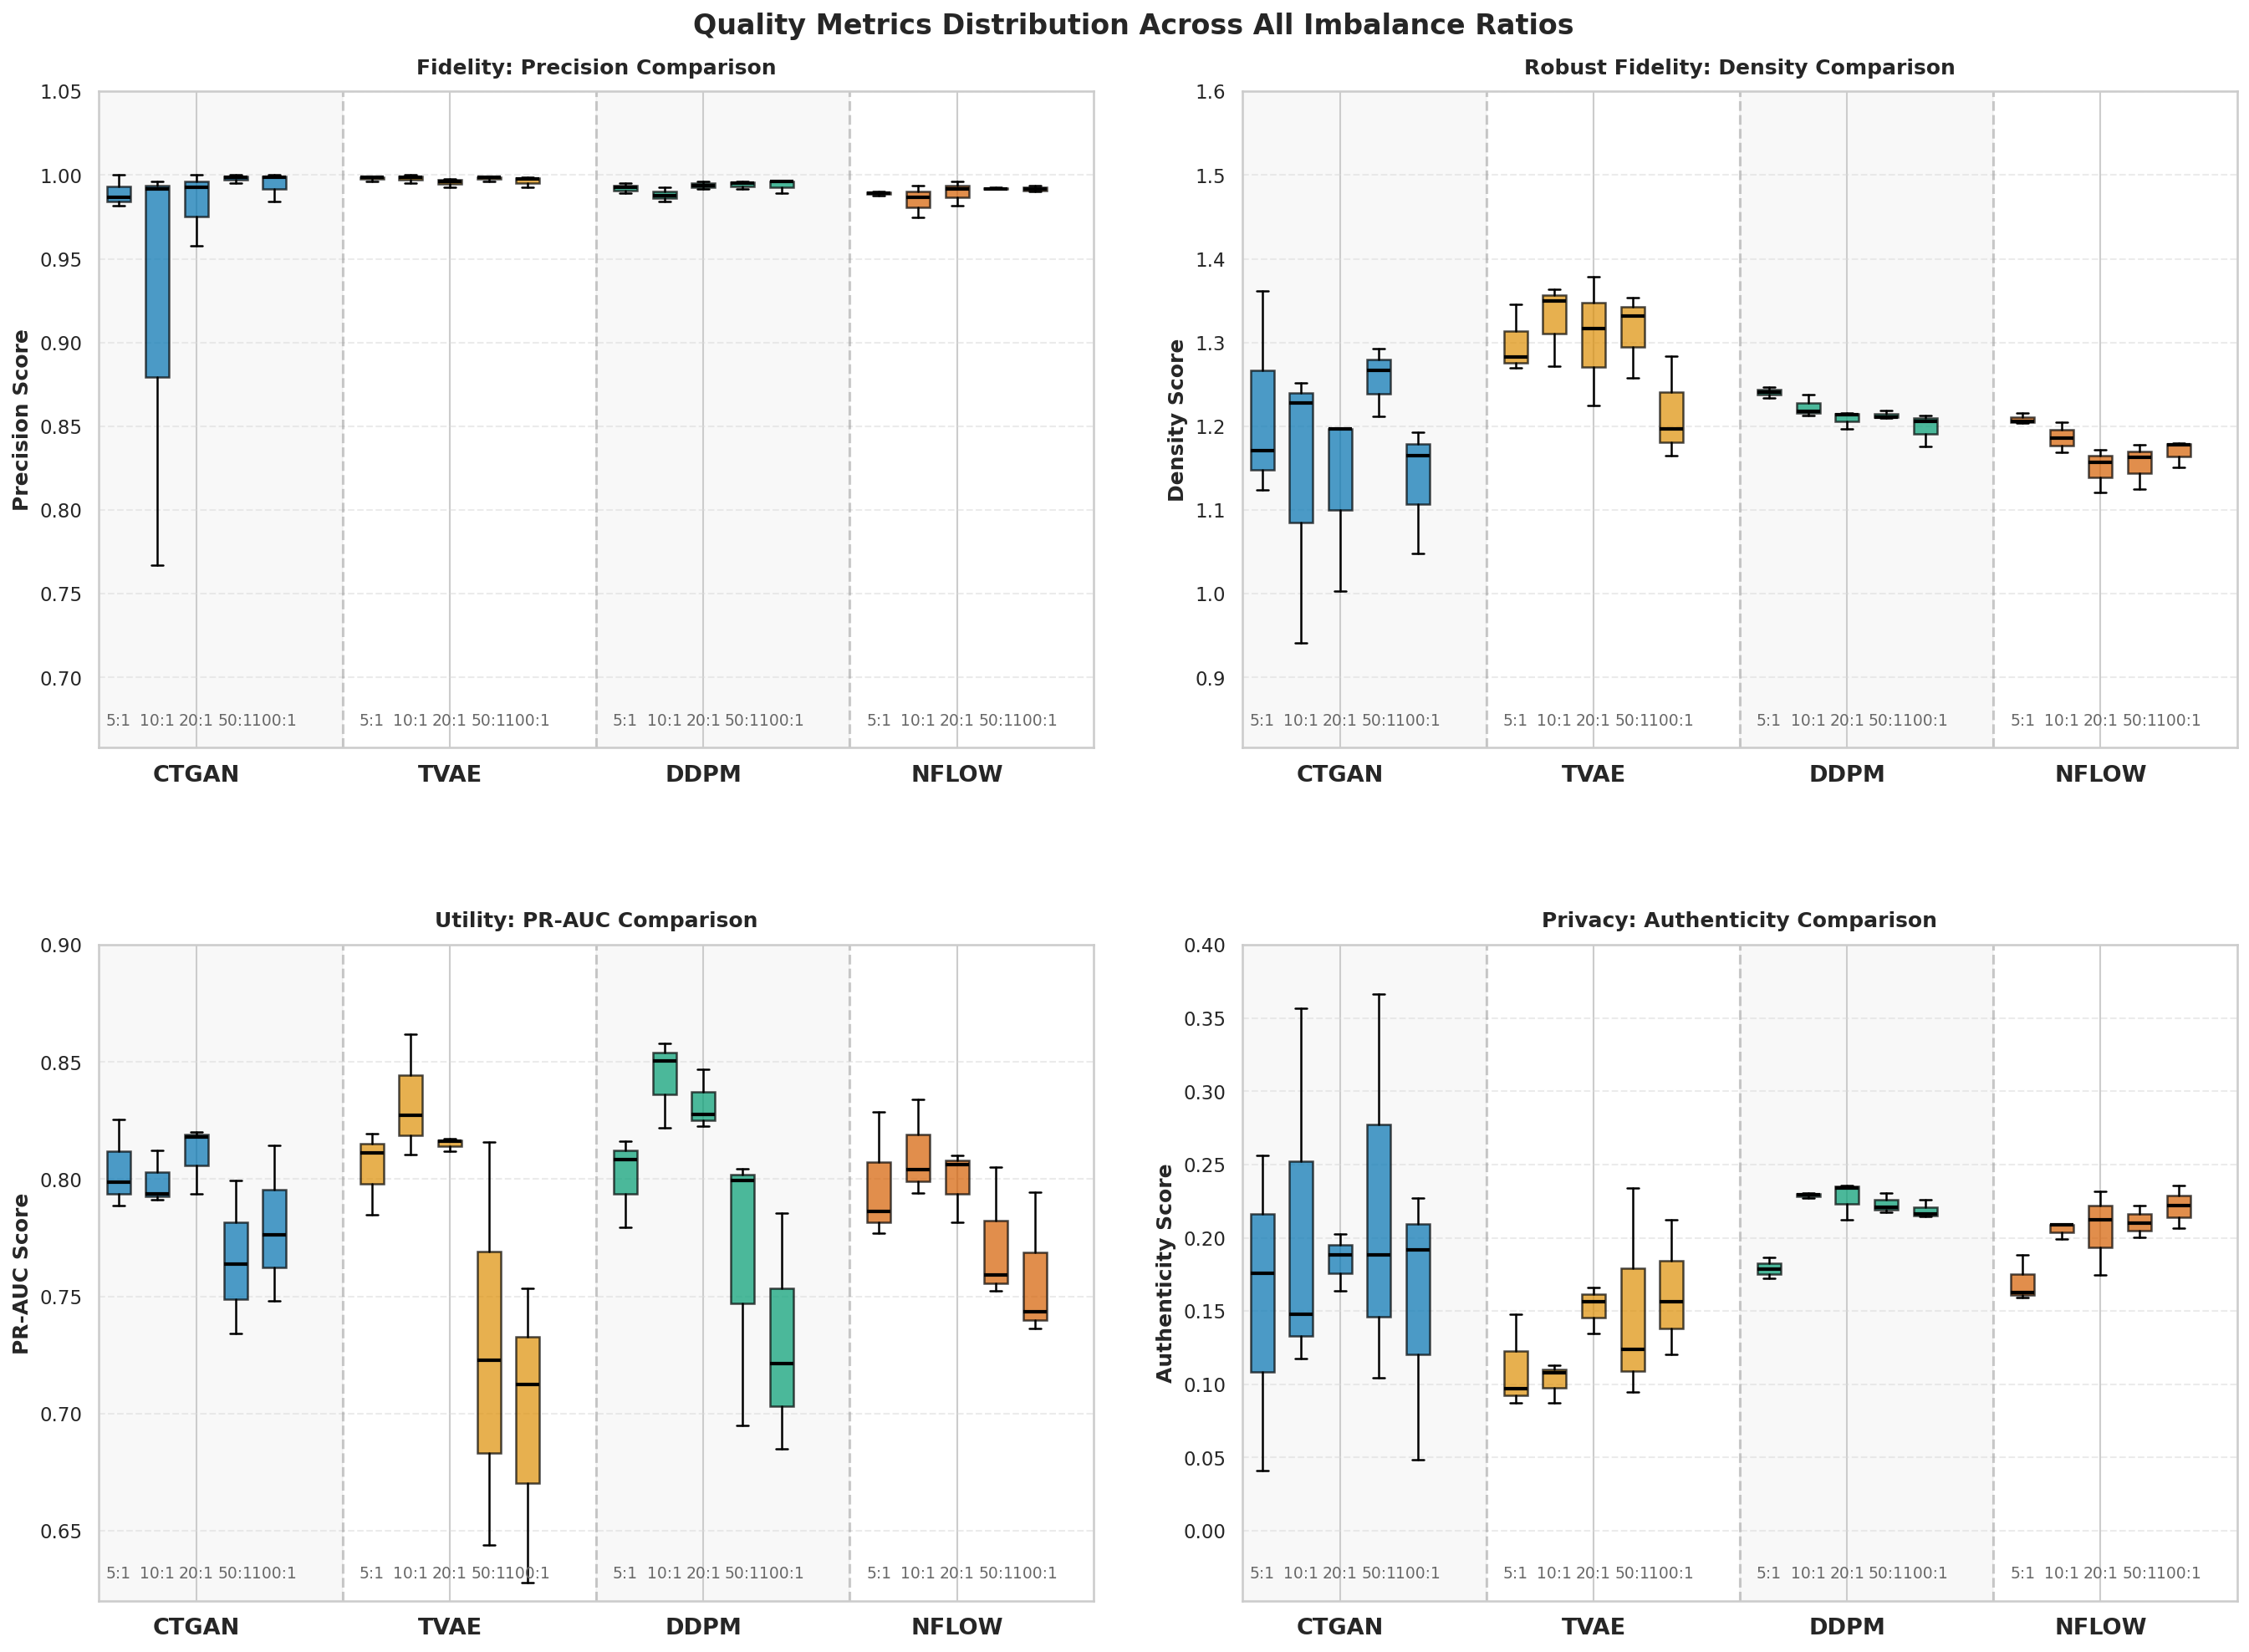


Aggregated generator comparison saved to: ../results/figures/quality_metrics_with_repetition_variability.png


In [30]:
def plot_metric_boxplots_all_generators(data, metric, ax, title, y_label, y_lim=(0, None)):
    plot_data = []
    positions = []
    colors = []
    ir_positions_per_gen = {gen: [] for gen in GENERATOR_STYLES.keys()}
    
    generators_list = list(GENERATOR_STYLES.keys())
    available_irs = sorted(data['ir'].unique())
    
    for i, gen in enumerate(generators_list):
        for j, ir in enumerate(available_irs):
            gen_data = data[(data['ir'] == ir) & (data['generator'] == gen)]
            if not gen_data.empty:
                values = gen_data[metric].values
                plot_data.append(values)
                pos = i * (len(available_irs) + 1.5) + j
                positions.append(pos)
                colors.append(GENERATOR_STYLES[gen]['color'])
                ir_positions_per_gen[gen].append((pos, ir))
    
    bp = ax.boxplot(plot_data, positions=positions, widths=0.6,
                    patch_artist=True, showfliers=True,
                    medianprops=dict(color='black', linewidth=2),
                    boxprops=dict(linewidth=1.2),
                    whiskerprops=dict(linewidth=1.2),
                    capprops=dict(linewidth=1.2),
                    flierprops=dict(marker='o', markerfacecolor='red', markersize=6, 
                                   markeredgecolor='darkred', linewidth=1))
    
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
        patch.set_edgecolor('black')
    
    tick_positions = [i * (len(available_irs) + 1.5) + (len(available_irs) - 1) / 2 
                     for i in range(len(generators_list))]
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(generators_list, fontsize=13, fontweight='bold')
    
    for i in range(1, len(generators_list)):
        x_pos = i * (len(available_irs) + 1.5) - 0.75
        ax.axvline(x=x_pos, color='gray', linestyle='--', linewidth=1.5, alpha=0.4)
    
    ax.set_ylabel(y_label, fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=12, fontweight='bold', pad=10)
    
    if y_lim:
        y_min, y_max = y_lim
        if y_max is None:
            y_max = ax.get_ylim()[1]
        if y_min is None:
            y_min = ax.get_ylim()[0]
    else:
        y_min, y_max = ax.get_ylim()
    
    y_range = y_max - y_min
    y_min_adjusted = y_min - y_range * 0.12
    ax.set_ylim(y_min_adjusted, y_max)
    
    y_pos = y_min - y_range * 0.06
    
    for gen in generators_list:
        if ir_positions_per_gen[gen]:
            for pos, ir in ir_positions_per_gen[gen]:
                ax.text(pos, y_pos, f'{ir}:1', 
                       ha='center', va='top', fontsize=9, 
                       rotation=0, color='dimgray')
    
    for i in range(0, len(generators_list), 2):
        x_start = i * (len(available_irs) + 1.5) - 0.75
        x_end = (i + 1) * (len(available_irs) + 1.5) - 0.75
        ax.axvspan(x_start, x_end, alpha=0.05, color='gray', zorder=0)
    
    ax.grid(True, axis='y', ls='--', c='0.85', alpha=0.5, zorder=0)
    ax.set_axisbelow(True)
    
    ax.set_xlim(-0.5, len(generators_list) * (len(available_irs) + 1.5) - 1)


fig, axes = plt.subplots(2, 2, figsize=(22, 14))
fig.suptitle('Quality Metrics Distribution Across All Imbalance Ratios',
             fontsize=16, fontweight='bold', y=0.985)

plot_metric_boxplots_all_generators(raw_results_df, 'precision', axes[0, 0], 
                                   'Fidelity: Precision Comparison', 
                                   'Precision Score', y_lim=(0.7, 1.05))

plot_metric_boxplots_all_generators(raw_results_df, 'density', axes[0, 1], 
                                   'Robust Fidelity: Density Comparison', 
                                   'Density Score', y_lim=(0.9, 1.6))

plot_metric_boxplots_all_generators(raw_results_df, 'pr_auc', axes[1, 0], 
                                   'Utility: PR-AUC Comparison', 
                                   'PR-AUC Score', y_lim=(0.65, 0.90))

plot_metric_boxplots_all_generators(raw_results_df, 'authenticity', axes[1, 1], 
                                   'Privacy: Authenticity Comparison', 
                                   'Authenticity Score', y_lim=(0, 0.4))

plt.subplots_adjust(bottom=0.08, top=0.94, hspace=0.30, wspace=0.15)
plt.savefig(FIGURES_PATH / 'quality_metrics_with_repetition_variability.png', 
           dpi=300, bbox_inches='tight')
plt.show()

print("\nAggregated generator comparison saved to:", FIGURES_PATH / 'quality_metrics_with_repetition_variability.png')

### 6.2.3. Overall Distribution: All Generators Combined

To understand the overall behavior across all generators, let's create boxplots that combine all generator results for each imbalance ratio. This view shows:
- **Overall distribution** of each metric regardless of generator
- **General trends** as imbalance increases
- **Overall variability** in synthetic data quality across all methods and repetitions

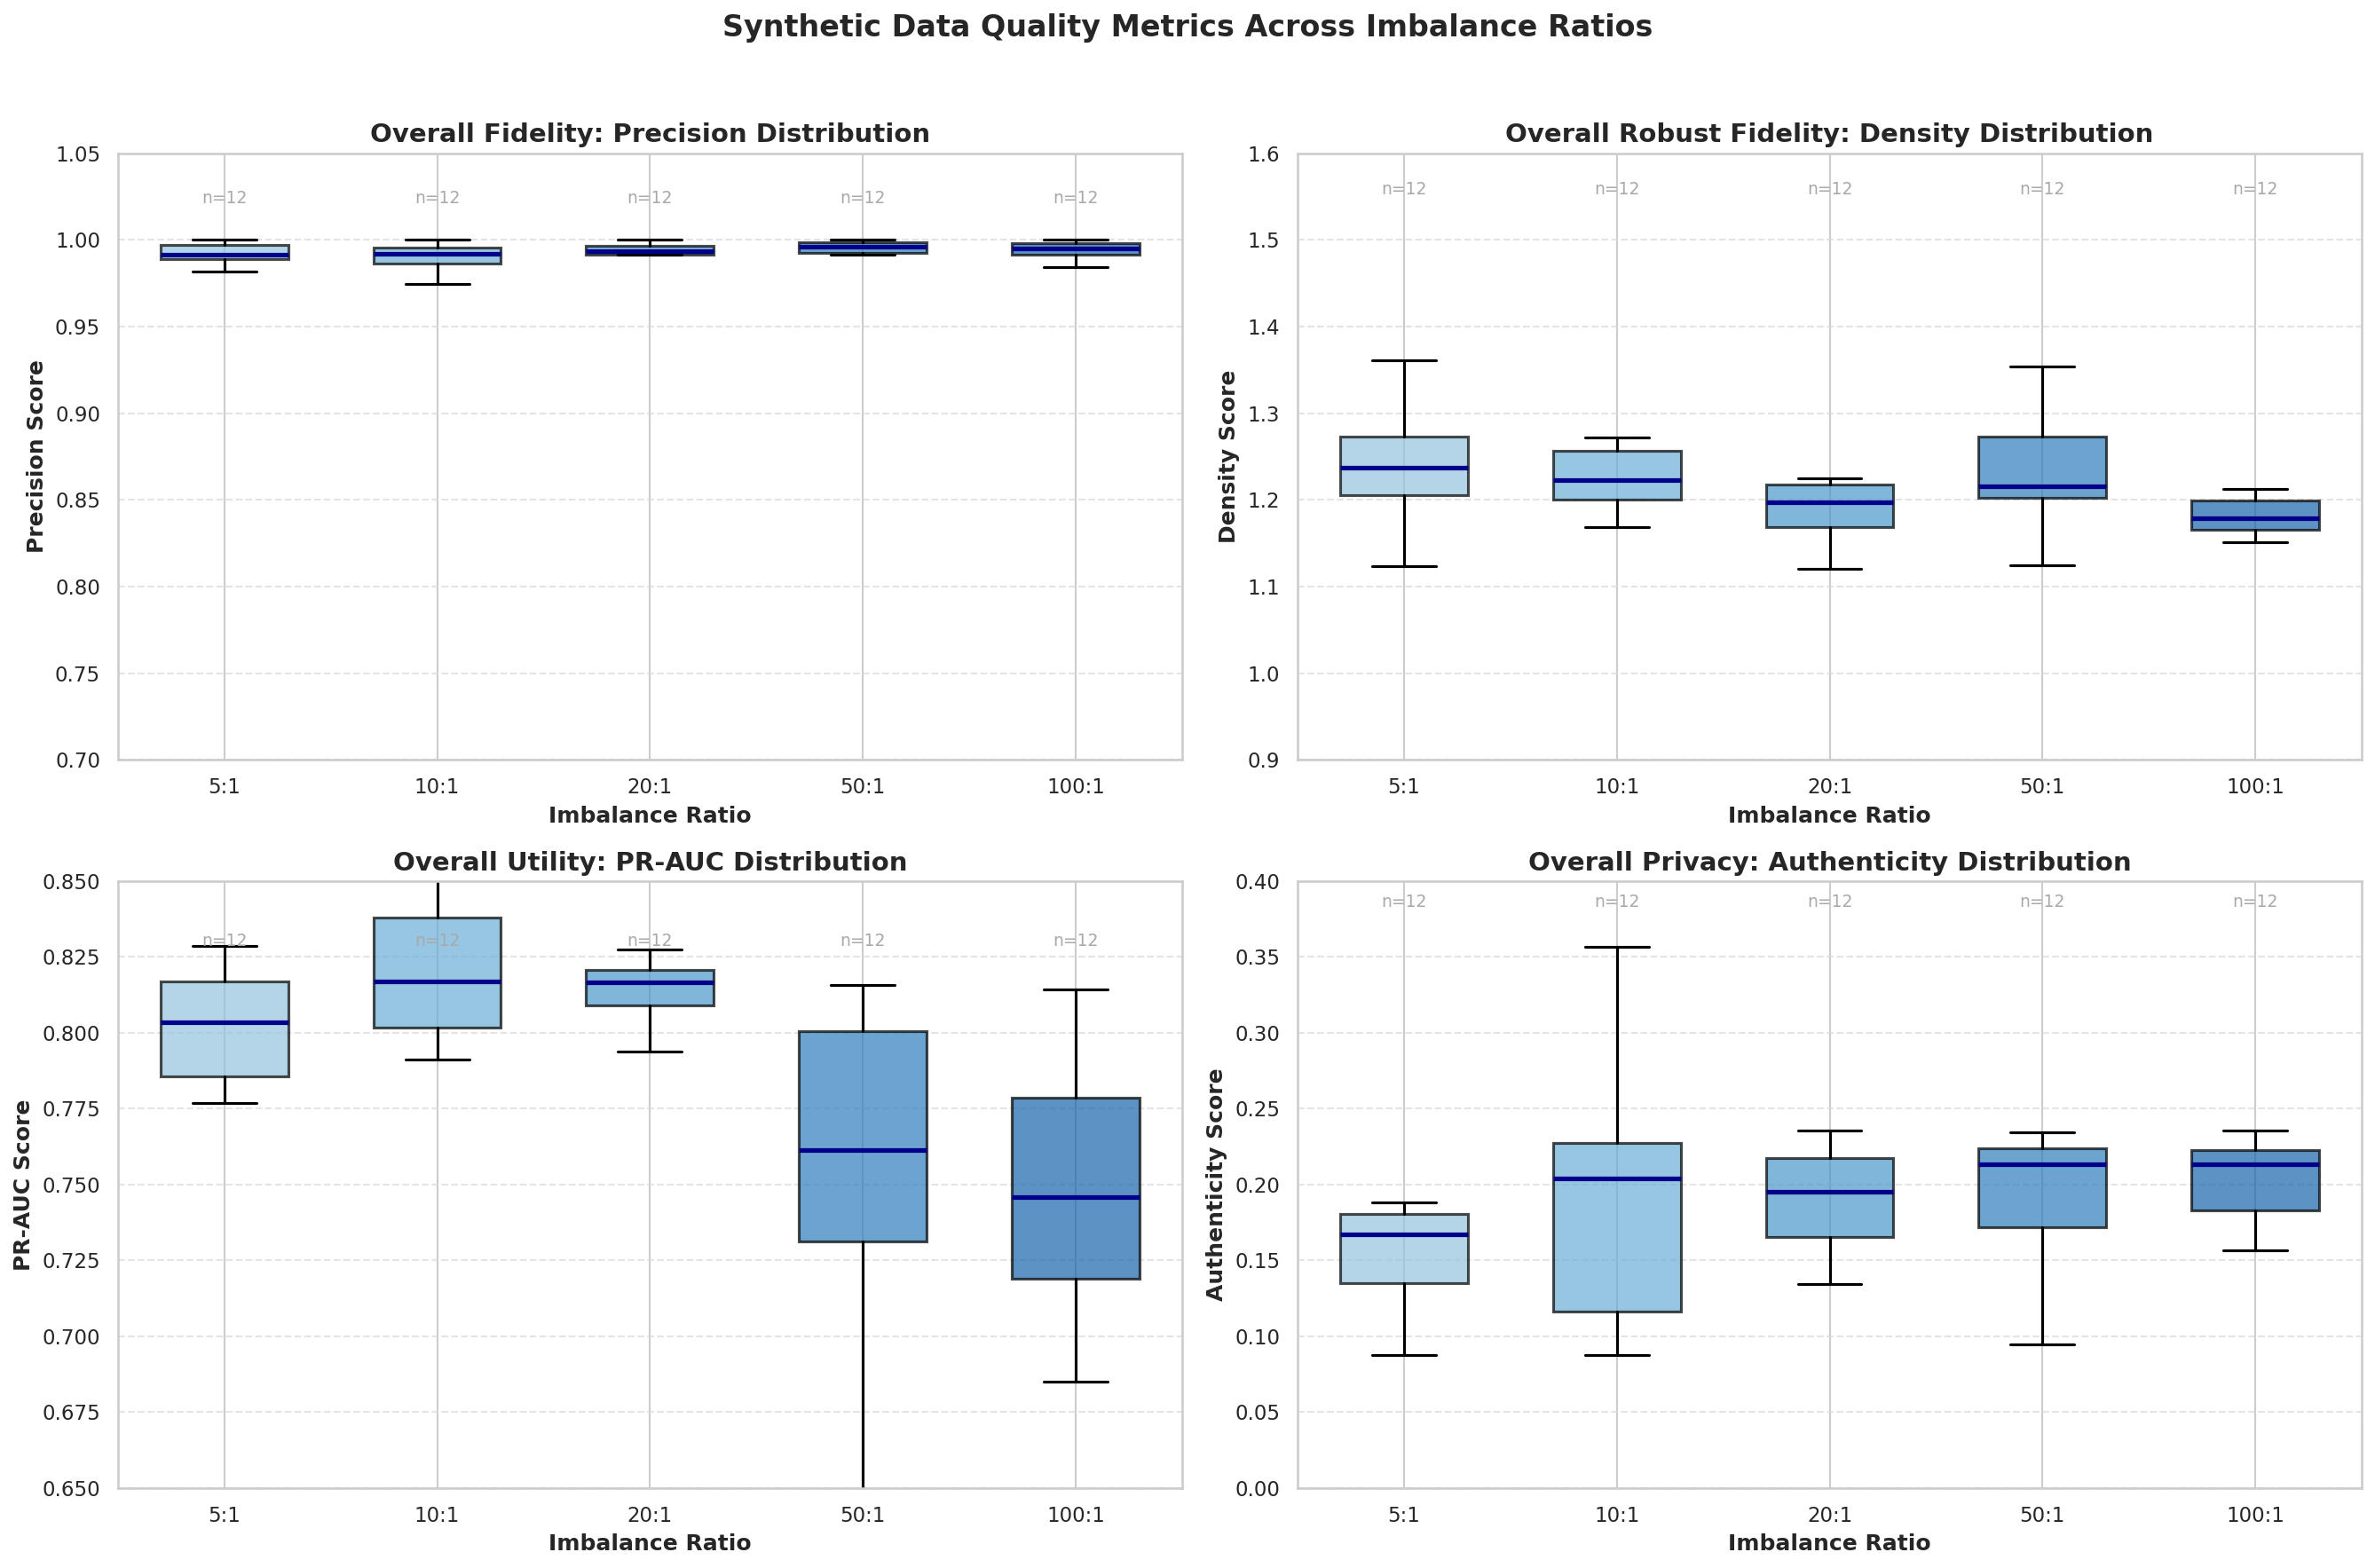

In [31]:
def plot_metric_boxplots_combined(data, metric, ax, title, y_label, y_lim=(0, None)):
    plot_data = []
    positions = []
    ir_labels = []
    
    for i, ir in enumerate(IMBALANCE_RATIOS):
        ir_data = data[data['ir'] == ir]
        if not ir_data.empty:
            values = ir_data[metric].values
            plot_data.append(values)
            positions.append(i)
            ir_labels.append(f"{ir}:1")
    
    bp = ax.boxplot(plot_data, positions=positions, widths=0.6,
                    patch_artist=True, showfliers=False,
                    medianprops=dict(color='darkblue', linewidth=2.5),
                    boxprops=dict(linewidth=1.5, facecolor='lightblue'),
                    whiskerprops=dict(linewidth=1.5),
                    capprops=dict(linewidth=1.5),
                    flierprops=dict(marker='o', markerfacecolor='red', markersize=8, 
                                   markeredgecolor='darkred', linewidth=1.5))
    
    colors = plt.cm.Blues(np.linspace(0.4, 0.8, len(plot_data)))
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax.set_xticks(positions)
    ax.set_xticklabels(ir_labels)
    ax.set_xlabel('Imbalance Ratio', fontsize=12, fontweight='bold')
    ax.set_ylabel(y_label, fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=14, fontweight='bold')
    
    if y_lim:
        ax.set_ylim(y_lim)
    
    for i, (pos, data_values) in enumerate(zip(positions, plot_data)):
        n_samples = len(data_values)
        ax.text(pos, ax.get_ylim()[1] * 0.98, f'n={n_samples}', 
               ha='center', va='top', fontsize=9, color='darkgray')
    
    ax.grid(True, axis='y', ls='--', c='0.85', alpha=0.7)

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Synthetic Data Quality Metrics Across Imbalance Ratios',
             fontsize=16, fontweight='bold')

plot_metric_boxplots_combined(raw_results_df, 'precision', axes[0, 0], 
                              'Overall Fidelity: Precision Distribution', 
                              'Precision Score', y_lim=(0.7, 1.05))

plot_metric_boxplots_combined(raw_results_df, 'density', axes[0, 1], 
                              'Overall Robust Fidelity: Density Distribution', 
                              'Density Score', y_lim=(0.9, 1.6))

plot_metric_boxplots_combined(raw_results_df, 'pr_auc', axes[1, 0], 
                              'Overall Utility: PR-AUC Distribution', 
                              'PR-AUC Score', y_lim=(0.65, 0.85))

plot_metric_boxplots_combined(raw_results_df, 'authenticity', axes[1, 1], 
                              'Overall Privacy: Authenticity Distribution', 
                              'Authenticity Score', y_lim=(0, 0.4))

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(FIGURES_PATH / 'overall_quality_distribution_combined.png', dpi=300)
plt.show()

### 6.4. Multi-Dimensional Quality Profile (Radar Chart)

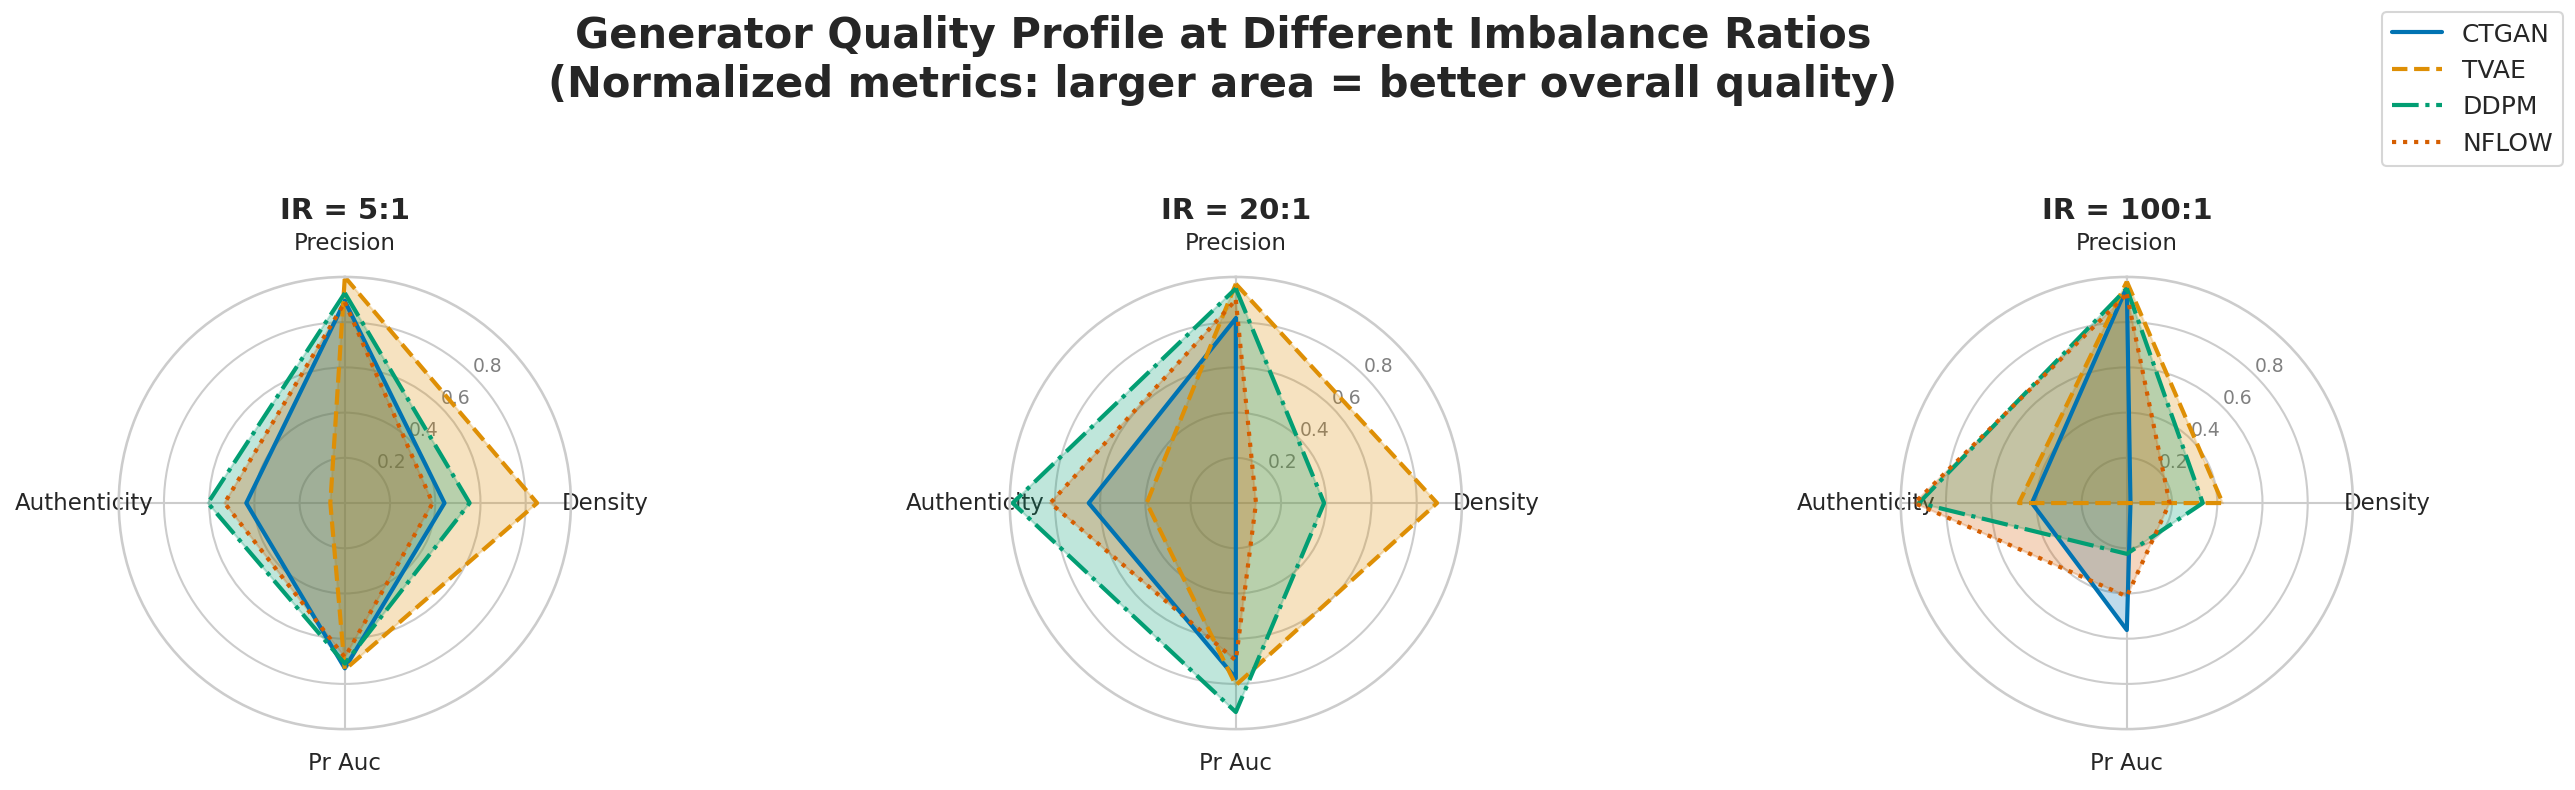

In [32]:
metrics_for_radar = ['precision', 'density', 'pr_auc', 'authenticity']
radar_df = results_df.copy()

for metric in metrics_for_radar:
    radar_df[metric] = radar_df[f"{metric}_mean"]

scaler = MinMaxScaler()
radar_df[metrics_for_radar] = scaler.fit_transform(radar_df[metrics_for_radar])


def plot_radar_chart(data, ir_level, ax):
    df_ir = data[data['ir'] == ir_level]
    labels = metrics_for_radar
    num_vars = len(labels)
    
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]  

    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    for gen, style in GENERATOR_STYLES.items():
        gen_data = df_ir[df_ir['generator'] == gen]
        if gen_data.empty:
            continue
            
        values = gen_data[labels].values.flatten().tolist()
        values += values[:1]  
        
        ax.plot(angles, values, color=style['color'], linewidth=2, 
                linestyle=style['linestyle'], label=gen)
        ax.fill(angles, values, color=style['color'], alpha=0.25)

    ax.set_rlabel_position(180 / num_vars)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels([l.replace('_', ' ').title() for l in labels], size=11)
    ax.set_yticks([0.2, 0.4, 0.6, 0.8])
    ax.set_yticklabels(["0.2", "0.4", "0.6", "0.8"], color="grey", size=9)
    ax.set_ylim(0, 1)
    ax.set_title(f"IR = {ir_level}:1", size=14, weight='bold', position=(0.5, 1.1))


fig, axes = plt.subplots(figsize=(18, 5), ncols=3, subplot_kw=dict(projection='polar'))
fig.suptitle('Generator Quality Profile at Different Imbalance Ratios\n(Normalized metrics: larger area = better overall quality)', 
             fontsize=20, fontweight='bold', y=1.05)

plot_radar_chart(radar_df, 5, axes[0])
plot_radar_chart(radar_df, 20, axes[1])
plot_radar_chart(radar_df, 100, axes[2])

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', fontsize=12)

plt.tight_layout()
plt.savefig(FIGURES_PATH / 'improved_radar_profiles.png', dpi=300, bbox_inches='tight')
plt.show()
